In [9]:
__updated__ = '2021-12-24 00:55:52'
from Calculator import Calculator as Calc
from PlotTools import plt, plotKBar, transforDate #createPlot
from utils import (
    pd, np, getSchema, getDateBeforeTrade, 
    saveRecommand, timedelta, GetException,
    sendResultTable, VolumeFilter, PriceFilter,
    changedType, datetime
)
from copy import deepcopy
import matplotlib.dates as mpl_dates
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [57]:
def getData(td:datetime=datetime.today(), ticker:str=""):
    
    schema = getSchema('TWSE')
    table = schema['historicalPrice']
    pre_3y = td + timedelta(-365*1)
    temp_df = pd.DataFrame(list(table.find({'Ticker':{'$eq':ticker},'Date':{'$gte':pre_3y.strftime('%Y-%m-%d')}}))).set_index('Date')# , '$lte':td.strftime('%Y-%m-%d')
    return temp_df

In [121]:
ticker = "2353"

df = getData(ticker=ticker)

In [122]:
predict_length = 60
predict_start = pd.to_datetime(df.index[-1])
predict_end = predict_start + timedelta(predict_length)
dates = pd.date_range(predict_start, predict_end)
dates = [x.strftime("%Y-%m-%d") for x in dates if x.isocalendar()[-1] <= 5][1:]

In [123]:
predict_start

Timestamp('2022-06-02 00:00:00')

In [124]:
mid_of_last = (df.High.iloc[-1] + df.Low.iloc[-1]) / 2

In [125]:
predict_data = []
for i, date in enumerate(dates):
    symmetric_raw = df.iloc[-(2+i)]
#     print(symmetric_raw)
#     print(symmetric_raw.Open)
#     break
    if symmetric_raw.Open > symmetric_raw.Close:
        # green
        predict_data.append({
            "Date":date,
            "Open":mid_of_last + (mid_of_last - min(symmetric_raw.Open, symmetric_raw.Close)),
            'High':mid_of_last + (mid_of_last - symmetric_raw.Low),
            'Low':mid_of_last + (mid_of_last - symmetric_raw.High),
            "Close":mid_of_last + (mid_of_last - max(symmetric_raw.Open, symmetric_raw.Close)),
        })
    elif symmetric_raw.Open < symmetric_raw.Close:
        #red
        predict_data.append({
            "Date":date,
            "Open":mid_of_last + (mid_of_last - max(symmetric_raw.Open, symmetric_raw.Close)),
            'High':mid_of_last + (mid_of_last - symmetric_raw.Low),
            'Low':mid_of_last + (mid_of_last - symmetric_raw.High),
            "Close":mid_of_last + (mid_of_last - min(symmetric_raw.Open, symmetric_raw.Close)),
        })
    else:
        predict_data.append({
            "Date":date,
            "Open":mid_of_last + (mid_of_last - max(symmetric_raw.Open, symmetric_raw.Close)),
            'High':mid_of_last + (mid_of_last - symmetric_raw.Low),
            'Low':mid_of_last + (mid_of_last - symmetric_raw.High),
            "Close":mid_of_last + (mid_of_last - min(symmetric_raw.Open, symmetric_raw.Close)),
        })

In [126]:
new_df = df.reset_index().append(pd.DataFrame(predict_data))['Date,Ticker,Open,High,Low,Close,Volume'.split(',')].fillna(method='ffill')

No handles with labels found to put in legend.
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



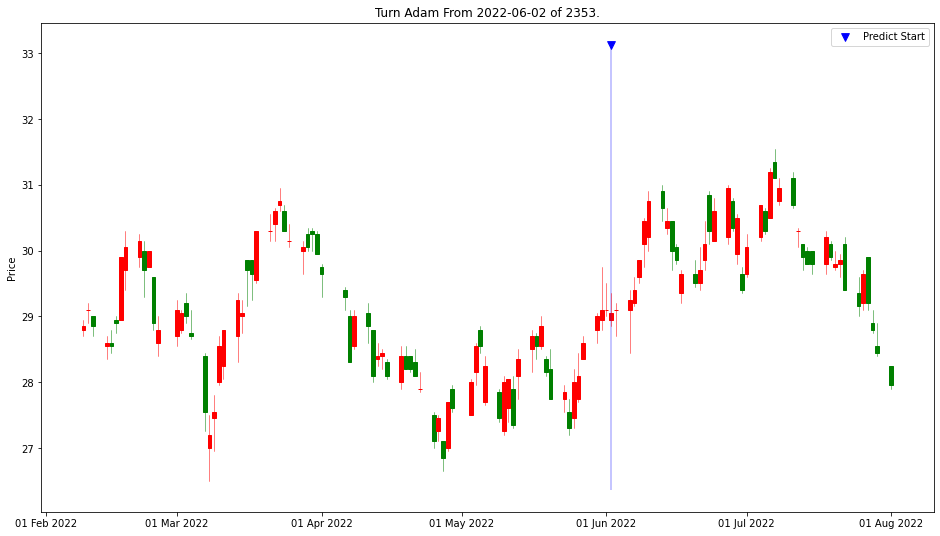

In [135]:
plt_df = new_df.copy(deep=True).tail(2 * predict_length)
fig, ax = plt.subplots(figsize=(16, 9))
plotKBar(ax, plt_df.set_index('Date'))
# plt_df.DateStr = plt_df.Date
plt_df.Date = plt_df.Date.apply(transforDate)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
plt.title(f"Turn Adam From {predict_start.strftime('%Y-%m-%d')} of {ticker}.")
# print(dates)
# print(list(new_df.Date))
# print(new_df[new_df.Date==dates[0]].High)
plt.scatter(predict_start, plt_df.High.max() * 1.05, marker="v", color='blue',s=60, label='Predict Start')
plt.vlines(predict_start, plt_df.Low.min() * .995, plt_df.High.max() * 1.05, color='blue', alpha=0.3)
plt.legend()
fig.show()

In [191]:
def PlotKBar(ticker, df, date=datetime(2021,2,18), ma_len=5, ma_len2=10, ma_len3 = 20, predict_start:datetime=None):
#     df = ReadDailyDataLonger(ticker, date)
    df['MA'] = df.Close.rolling(ma_len).mean()
    df['MA2'] = df.Close.rolling(ma_len2).mean()
    df['MA3'] = df.Close.rolling(ma_len3).mean()
    df['Adj V'] = df.Volume.apply(lambda x: int(float(x)/1000))
    df.Date = pd.to_datetime(df.Date)
    start_date = df.Date.iloc[0]
    end_date = df.Date.iloc[-1]
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.3, 
                        subplot_titles=(f'OHLC and MA of {ticker} From {start_date} to {end_date}', 'Volume'), 
                        row_width=[0.2, 0.7])
    
    fig.add_trace(go.Candlestick(x=df.Date,
                    open=df.Open,
                    high=df.High,
                    low=df.Low,
                    close=df.Close,
                    name="CandleStick"), row=1,col=1)
    fig.add_trace(
        go.Scatter(
            x=df.Date,
            y=df.MA,
            name=f"MA{ma_len}"
        ), row=1,col=1)
    fig.add_trace(
        go.Scatter(
            x=df.Date,
            y=df.MA2,
            name=f"MA{ma_len2}"
        ), row=1,col=1)
    fig.add_trace(
        go.Scatter(
            x=df.Date,
            y=df.MA3,
            name=f"MA{ma_len3}"
        ), row=1,col=1)
    if predict_start:
        fig.add_trace(
        go.Scatter(
            x=[predict_start]*100,
            y=list(np.linspace(df.Low.min(),df.High.max(), 100)),#[],
            name=f"Predict Start Date {predict_start.strftime('%Y-%m-%d')}",
            opacity=.9,
            line = dict(color='royalblue', width=1, dash='dash')
#             color
        ), row=1,col=1)
    
    fig.add_trace(go.Bar(x=df.Date, y=df['Adj V'], showlegend=False, name = "Volume"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['Adj V'].rolling(5).mean(), showlegend=False, name="VMA5"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['Adj V'].rolling(20).mean(), showlegend=False, name="VMA20"), row=2, col=1)
    test_df = df.copy(deep=True)
#     test_df.Date = pd.to_datetime(test_df.Date)
    begin_date, end_date = [start_date, end_date]
    test_df = test_df.set_index("Date").reindex(pd.date_range(begin_date, end_date, freq='D'))
    datebreaks = test_df['Close'][test_df['Close'].isnull()].index
#     fig.update_layout(shapes=[
#         dict(
#             type= 'line',
#             yref= 'paper', y0= [df.Low.min()], y1= [df.High.max()],
#             xref= 'x', x0= [predict_start], x1= [predict_start]
#     )])
    fig.update_xaxes(rangebreaks=[dict(values=datebreaks)])
    fig.show()

In [192]:
PlotKBar(ticker, new_df.copy(deep=True).tail(2 * predict_length), predict_start=predict_start)